# Solving the BBM equation numerically

In [1]:
import autograd.numpy as np
from autograd import elementwise_grad
import numpy.linalg as la
from scipy.sparse import spdiags

import matplotlib.pyplot as plt
colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]

## The Benjamin–Bona–Mahony equation

In this notebook, we consider the one-dimensional (damped and forced) Benjamin–Bona–Mahony (BBM) equation for waves on shallow water. It is given by
\begin{equation}
u_t  - u_{xxt} + u_x + u u_x - \nu u_{xx} = g(x,t).
\label{eq:kdv} \tag{1}
\end{equation}
If $\nu > 0$, it is the damped BBM equation. If $\nu=0$ and $g(x,t) = 0$, we have the standard, i.e. unforced and undamped, BBM equation equation.

For the standard BBM equation, the energy given by
$$
\begin{align*}
\mathcal{H}[u] &= \frac{1}{2} \int_\mathbb{R} \left(u^2 + \frac{1}{3}u^3 \right)\, dx
\end{align*}
$$
is conserved, i.e. constant over time.

To get it on the standard form of a Hamiltonian PDE, we introduce the variable $m(x,t) := u(x,t) - u_{xx}(x,t)$, and have that
$$
\begin{align*}
m_t &= S(x,m^J) \frac{\delta \mathcal{H}}{\delta m}
\end{align*}
$$
for $S(x,m^J) = -\partial_x + \partial_{xxx} = - (1 - \partial_{xx})\partial_x$, since
$$
\begin{align*}
\frac{\delta\mathcal{H}}{\delta m}[u] &= \frac{\delta u}{\delta m} \frac{\delta\mathcal{H}}{\delta u}[u] \\
& = (1-\partial_{xx})^{-1} (u + \frac{1}{2}u^2).
\end{align*}
$$

That is,
\begin{equation}
u_t - u_{xxt} = - \frac{\partial}{\partial x} \left( u  + \frac{1}{2}u^2 \right),
\label{eq:kdvmod} \tag{2}
\end{equation}
which we see is equivalent to (1) for $\nu=0$ and $g(x,t) = 0$.

Similarly, we see that we can write the full version (1) on the form
$$
D(x,u^J) u_t = S(x,u^J)\dfrac{\delta \mathcal{H}}{\delta u}[u] - \dfrac{\delta \mathcal{V}}{\delta u}[u] + g(x,t),
$$
with $D(x,u^J) = 1- \frac{\partial^2}{\partial x^2}$, $S(x,u^J) = -\frac{\partial}{\partial x}$ and
$$
\mathcal{V} = \frac{\nu}{2}\int_\mathbb{R} u_x^2 \, dx.
$$

### Analytic solution
Like the KdV equation, the standard BBM equation has a soliton solution that can be derived analytically. That is, for the inital condition
$$
u(x,0) = 3 (c-1) \, \mathrm{sech}^2 \left(\frac{1}{2}\sqrt{1-\frac{1}{c}}(-x + P/2)\right),
$$
and periodic boundary conditions $u(P,t) = u(0,t)$ for all $t\geq0$, the exact solution at all times is
$$
u(x,t) = 3 (c-1)  \, \mathrm{sech}^2 \left(\frac{1}{2}\sqrt{1-\frac{1}{c}}\lvert (x - c t) \, \mathrm{mod} \, P - P/2\rvert \right).
$$

In [2]:
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

In [3]:
c = 3 # the speed
P = 50 # period
M = 100 # number of spatial points
x, dx = grid(P, M)
sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
u_soliton = lambda x, t: 3*(c-1)*sech(1/2*np.sqrt(1-1/c)*(np.abs((x-c*t) % P - P/2)))**2

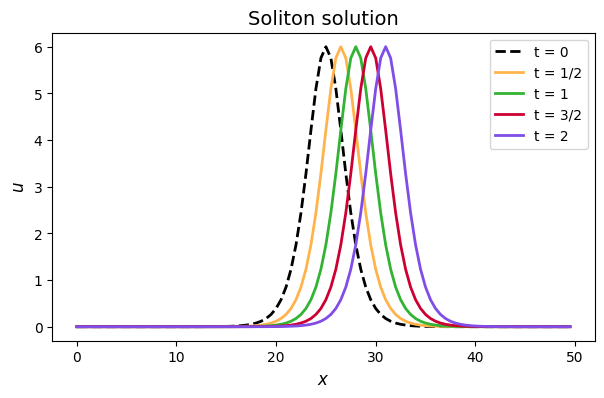

In [4]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u_soliton(x, 0), 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u_soliton(x, 1/2), color = colors[1], linewidth=lw, label='t = 1/2')  
plt.plot(x, u_soliton(x, 1), color = colors[2], linewidth=lw, label='t = 1')  
plt.plot(x, u_soliton(x, 3/2), color = colors[3], linewidth=lw, label='t = 3/2')  
plt.plot(x, u_soliton(x, 2), color = colors[4], linewidth=lw, label='t = 2')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Soliton solution', fontsize=14)
plt.legend()
plt.show()

Observe that the height of the wave is $6 = 3 (c-1)$, and the speed is $3=c$.

In general, however, the BBM equation does not have an analytic solution, and thus has to be solved by numerical methods.

## Discretizing in space

In [5]:
def difference_matrices(P=20, M=100):
    dx = P/M
    e = np.ones(M) # unit vector of length M
    # 1st order central difference matrix:
    D1 = .5/dx*spdiags([e,-e,e,-e], np.array([-M+1,-1,1,M-1]), M, M).toarray()
    # 2nd order central difference matrix:
    D2 = 1/dx**2*spdiags([e,e,-2*e,e,e], np.array([-M+1,-1,0,1,M-1]), M, M).toarray()
    return D1, D2

### Semi-discrete formulation as a system of ODEs

Using the difference operators to approximate the spatial derivatives of (2) with an additional forcing term, we get
\begin{equation}
(I-D_c^2)\mathbf{u}_t = - D_c^1 (\mathbf{u} + \frac{1}{2} \mathbf{u}^2) + \mathbf{g}(t),
\label{eq:kdv_disc} \tag{3}
\end{equation}
where $I$ is the identity matrix and
\begin{align}
\mathbf{g}(t) = 
\begin{pmatrix}
    g(x_0,t) \\
    g(x_1,t) \\
    \vdots \\
    g(x_{M-1},t)
\end{pmatrix},
\end{align}
and $\mathbf{u}^2$ is the element-wise square of $\mathbf{u}$.

In [6]:
# At this point we need to decide on the grid that we want to use in the time-integration to follow:
P = 50
M = 100 # increase or decrease M to see how the approximation gets better/worse
x, dx = grid(P, M)
D1, D2 = difference_matrices(P,M)

In [7]:
# We must also define g:
g = lambda x, t: 0

In [8]:
# Define f so that u_t = f is (3)
I = np.eye(M)
f = lambda u, t: np.linalg.solve(I-D2, -np.matmul(D1, u + .5*u**2) + g(x, t))

## Integration in time

For the semi-discretized BBM equation, we have
$$
f(\mathbf{u}, t) = (I-D_c^2)^{-1} (- D_c^1 (\mathbf{u} + \frac{1}{2} \mathbf{u}^2) + \mathbf{g}(t))
$$
and
$$
\frac{\partial}{\partial \mathbf{u}} f(\mathbf{u}, t) = - (I-D_c^2)^{-1} D_c^1 (I + \mathrm{diag}(\mathbf{u)}),
$$
where $\mathrm{diag}(\mathbf{u})$ is an $M \times M$ diagonal matrix with $\mathbf{u}$ on the diagonal.

In [9]:
u0 = u_soliton(x,0)
# f = lambda u, t: np.linalg.solve(I-D2, -np.matmul(D1, u + .5*u**2) + g(x, t)) # same as above
Df = lambda u: np.linalg.solve(I-D2, -np.matmul(D1, I + np.diag(u)))

In [10]:
def midpoint_method(u,un,t,f,Df,dt,M,tol,max_iter):
    '''
    Integrating one step of the ODE u_t = f, from u to un,
    with the implicit midpoint method
    Using Newton's method to find un
    '''
    I = np.eye(M)
    F = lambda u_hat: 1/dt*(u_hat-u) - f((u+u_hat)/2, t+.5*dt)
    J = lambda u_hat: 1/dt*I - 1/2*Df((u+u_hat)/2)
    err = la.norm(F(un))
    it = 0
    while err > tol:
        un = un - la.solve(J(un),F(un))
        err = la.norm(F(un))
        it += 1
        if it > max_iter:
            break
    return un

In [11]:
t_max = 2
N = 100
t, dt = grid(t_max, N)
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0

In [12]:
# The implicit midpoint method:
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

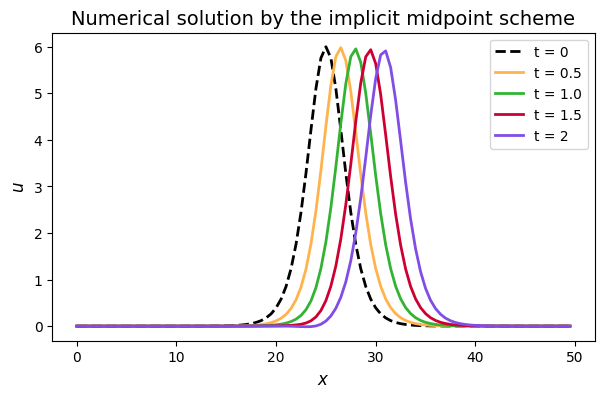

In [13]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u[0,:], 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u[int(N/4),:], color = colors[1], linewidth=lw, label=f't = {1/4*t_max}')  
plt.plot(x, u[int(N/2),:], color = colors[2], linewidth=lw, label=f't = {1/2*t_max}')  
plt.plot(x, u[int(3*N/4),:], color = colors[3], linewidth=lw, label=f't = {3/4*t_max}')  
plt.plot(x, u[-1,:], color = colors[4], linewidth=lw, label=f't = {t_max}')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Numerical solution by the implicit midpoint scheme', fontsize=14)
plt.legend()
plt.show()

## A more advanced problem

Let us then consider also problems that do not have an analytic solution, e.g. a system with two waves:

In [14]:
def initial_condition_bbm(x=np.linspace(0,20.-.2,100)):
    M = x.size
    P = int((x[-1]-x[0])*M/(M-1))
    c1, c2 = 3., 2.
    d1, d2 = .25, .5
    u0 = 0
    u0 += 3*(c1-1) * sech(1/2*np.sqrt(1 - 1/c1)*((x+P/2-P*d1) % P - P/2))**2
    u0 += 3*(c2-1) * sech(1/2*np.sqrt(1 - 1/c2)*((x+P/2-P*d2) % P - P/2))**2
    u0 = np.concatenate([u0[M:], u0[:M]], axis=-1)
    return u0

Define the spatial grid:

In [15]:
P = 40
M = 100 # increase or decrease M to see how the approximation gets better/worse
x, dx = grid(P, M)
D1, D2 = difference_matrices(P,M)

In [16]:
u0 = initial_condition_bbm(x)

And let us also consider the case of an external force acting on the system:

In [36]:
# g = lambda x, t: 3*np.sin(2*np.pi*t)
g = lambda x, t: 0*np.sin(2*np.pi/P*x)*np.ones_like(t)
#g = lambda x, t: 3*np.sin(2*np.pi/P*x)*np.sin(2*np.pi*t)
f = lambda u, t: np.linalg.solve(I-D2, -np.matmul(D1, u + .5*u**2) + g(x, t))
Df = lambda u: np.linalg.solve(I-D2, -np.matmul(D1, I + np.diag(u)))

Define the temporal grid:

In [37]:
t_max = 12
N = 300
t, dt = grid(t_max, N)

Integrate with the implicit midpoint method:

In [38]:
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

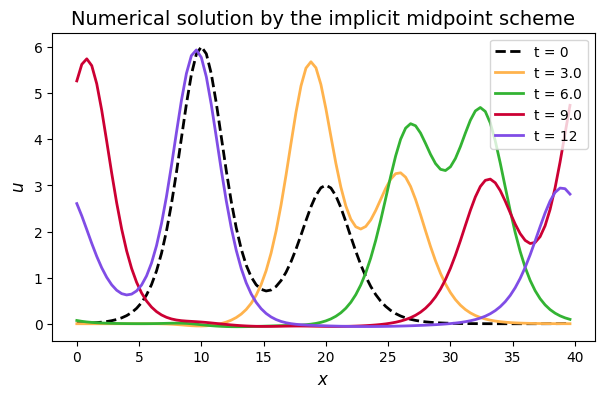

In [39]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u[0,:], 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u[int(N/4),:], color = colors[1], linewidth=lw, label=f't = {1/4*t_max}')  
plt.plot(x, u[int(N/2),:], color = colors[2], linewidth=lw, label=f't = {1/2*t_max}')  
plt.plot(x, u[int(3*N/4),:], color = colors[3], linewidth=lw, label=f't = {3/4*t_max}')  
plt.plot(x, u[-1,:], color = colors[4], linewidth=lw, label=f't = {t_max}')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Numerical solution by the implicit midpoint scheme', fontsize=14)
plt.legend()
plt.show()